# Partial Fourier Series with Quantum Computers

<!--
Resources:
- [Complex Fourier Series](https://npflueger.people.amherst.edu/math19/1201%20Complex%20Fourier%20Series.pdf)
- [The effect of data encoding on the expressive power of variational quantum machine learning models](https://arxiv.org/abs/2008.08605)
-->

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [69]:
def square_loss(y_true, y_preds):
    loss = 0
    for i in range(len(y_true)):
        loss += (y_true[i]-y_preds[i])**2
    loss /= len(y_true)
    return loss

In [20]:
degree = 1
scaling = 1

coeffs = [0.15 + 0.15j] * degree
coeff0 = 0.1

def target_function(x):
    """
    Generate a truncated Fourier Series
    """
    res = coeff0
    for i, c in enumerate(coeffs):
        exponent = scaling * (i+1) * x * 1j
        conj_c = np.conjugate(c)
        res += c * np.exp(exponent) + conj_c * np.exp(-exponent)
        return np.real(res)

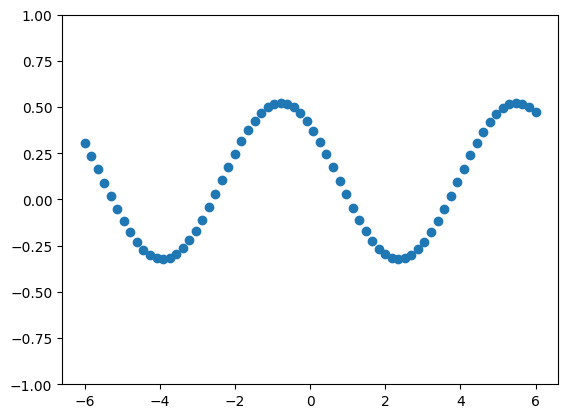

In [57]:
x = np.linspace(-6, 6, 70)
y = np.array([target_function(xi) for xi in x])
plt.scatter(x, y)
plt.ylim(-1, 1)
plt.show()

In [31]:
scaling = 1
dev = qml.device("default.qubit", wires=1)

def S(x):
    qml.RX(scaling * x, wires=0)

def W(theta):
    qml.Rot(*theta, wires=0)

@qml.qnode(dev)
def circuit(weights, x):
    for t in weights[:-1]:
        W(t)
        S(x)
    W(weights[-1])
    return qml.expval(qml.Z(0))

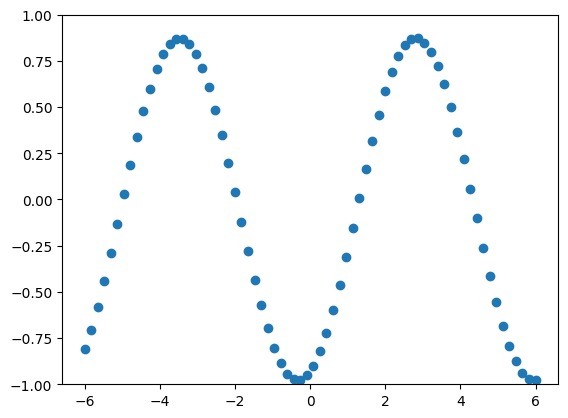

In [62]:
depth = 1
weights_init = 2 * np.pi * np.random.random(size=(depth+1, 3), requires_grad=True)
random_model = [circuit(weights_init, xi) for xi in x]
plt.scatter(x, random_model)
plt.ylim(-1, 1)
plt.show()

In [63]:
print(qml.draw(circuit, expansion_strategy="device")(weights_init, x[0]))

0: ──Rot(5.68,5.62,2.18)──RX(-6.00)──Rot(4.14,3.42,1.68)─┤  <Z>


In [74]:
def cost(weights, x, y):
    y_preds = [circuit(weights, xi) for xi in x]
    return square_loss(y, y_preds)

steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cost_ = [cost(weights_init, x, y)]
weights = weights_init

for s in range(steps):
    batch_items = np.random.randint(0, len(x), (batch_size, ))
    weights, cost_batch = opt.step_and_cost(cost, weights, x=x[batch_items], y=y[batch_items])

    cost_.append(cost_batch)

    if s%5==0 or s==steps-1:
        print(f"Step: {s} | Cost: {cost_batch}")

Step: 0 | Cost: 0.6480141261621449
Step: 5 | Cost: 0.299243103965326
Step: 10 | Cost: 0.025111388189787233
Step: 15 | Cost: 0.06743383490574364
Step: 20 | Cost: 0.006017181247386629
Step: 25 | Cost: 0.0128753166067197
Step: 30 | Cost: 0.017827455709198744
Step: 35 | Cost: 0.0031442306854572873
Step: 40 | Cost: 0.0029747367292466773
Step: 45 | Cost: 0.0008255828219303956
Step: 49 | Cost: 0.0020733949716180886


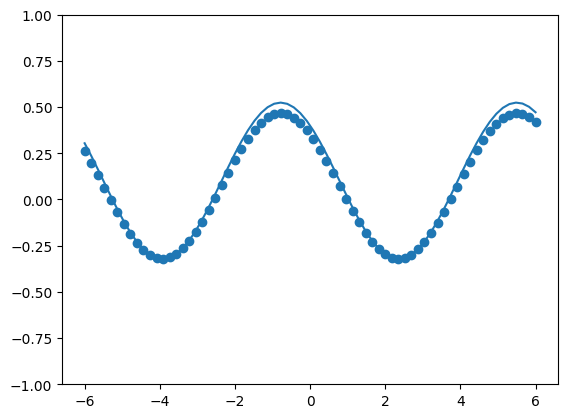

In [76]:
y_preds = [circuit(weights, xi) for xi in x]
plt.plot(x, y)
plt.scatter(x, y_preds)
plt.ylim(-1, 1)
plt.show()

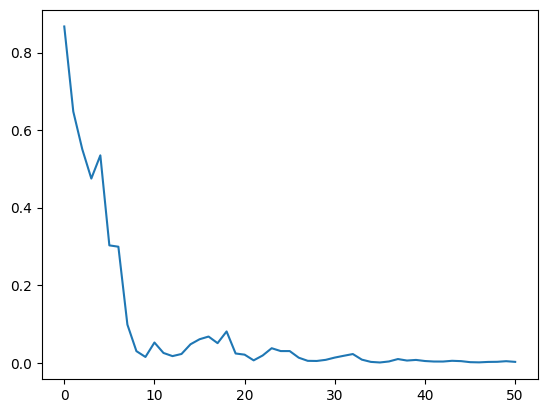

In [78]:
plt.plot(range(len(cost_)), cost_)
plt.show()